# Matching estimators of causal effects
## Agenda

- matching as conditioning via stratification
- matching as weighting
- matching as data analysis algorithm

## Hardware

In [1]:
%%bash
system_profiler SPHardwareDataType | grep -E \
"Model Identifier"\|"Processor Name"\|"Processor Speed"\
\|"Number of Processors"\|"Memory:"

      Model Identifier: MacBookPro13,1
      Processor Name: Dual-Core Intel Core i5
      Processor Speed: 2 GHz
      Number of Processors: 1
      Memory: 16 GB


### Python

In [2]:
!python3 -V

Python 3.7.4


### IMPORT

In [3]:
import statsmodels.formula.api as smf
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

## 1. Matching as conditioning via stratification

- $Y$: observed outcome
- $(Y_1, Y_0)$: potential outcomes
- $D$: treatment status
- X: covariates

Conditional independence assumptionが成立していると仮定する：

$$
(Y_0, Y_1) \perp D|X
$$
 
つまり

$$
\begin{aligned}
E[Y_1|D = 1, X] &= E[Y_1|D = 0, X]\\
E[Y_0|D = 1, X] &= E[Y_0|D = 0, X]
\end{aligned}
$$


### simulation datasetの作成

In [4]:
def generate_matching_data(sample_size):
    
    def set_potential_outcome(x):
        noise = np.random.normal(loc = 0, scale = 1, size = 2)
        if x == 1:
            y_1, y_0 = 4, 2
        elif x == 2:
            y_1, y_0 = 8, 5
        elif x == 3:
            y_1, y_0 = 14, 10
        else:
            raise AssertionError('X is wrong')
        
        y_1 += noise[0]
        y_0 += noise[1]
        
        return y_1, y_0
    
    col_info = dict()
    col_info['Y'] = np.float
    col_info['D'] = np.int
    col_info['X'] = np.int
    col_info['Y_1'] = np.float
    col_info['Y_0'] = np.float
    
    df = pd.DataFrame(columns = col_info.keys())
    
    for i in range(sample_size):
        u = np.random.uniform()
        if u < 0.36:
            x, d = 1, 0
        elif 0.36 <= u < 0.48:
            x, d = 2, 0
        elif 0.48 <= u < 0.60:
            x, d = 3, 0
        elif 0.60 <= u < 0.68:
            x, d = 1, 1
        elif 0.68 <= u < 0.80:
            x, d = 2, 1
        else:
            x, d = 3, 1
        
        y_1, y_0 = set_potential_outcome(x)
        y = d * y_1 + (1 - d)*y_0
        
        df.loc[i] = y, d, x, y_1, y_0
    
    df = df.astype(col_info)
    
    return df

In [5]:
df = generate_matching_data(sample_size = 10000)
df.head()

,Y,D,X,Y_1,Y_0
0,2.212647,0,1,4.270745,2.212647
1,15.395109,1,3,15.395109,11.554847
2,1.776871,0,1,5.125978,1.776871
3,3.520867,0,1,3.460276,3.520867
4,8.995658,0,3,14.190106,8.995658


### Sample Average treatment Effect

In [6]:
SATE = np.mean(df['Y_1'] - df['Y_0'])
SATE

2.8857580040278035

### Naive estimator

In [7]:
stat = df.loc[df['D'] == 1, 'Y'].mean() - df.loc[df['D'] == 0, 'Y'].mean()
print('The naive estimate is {:5.3f}'.format(stat))

The naive estimate is 5.920


### Distribution check

In [8]:
pivot_df = pd.pivot_table(df, index = 'D', columns = 'X', aggfunc='size',
                          fill_value=0)
pivot_df['cum_sum'] = pivot_df.sum(axis = 1)
pivot_df

X,1,2,3,cum_sum
D,,,,
0,3617,1188,1224,6029
1,836,1157,1978,3971


In [9]:
pivot_df = pivot_df.div(pivot_df.iloc[:, -1], axis = 0)
pivot_df

X,1,2,3,cum_sum
D,,,,
0,0.599934,0.197048,0.203019,1.0
1,0.210526,0.291362,0.498111,1.0


treatment statusによってXの分布が異なることがわかる。

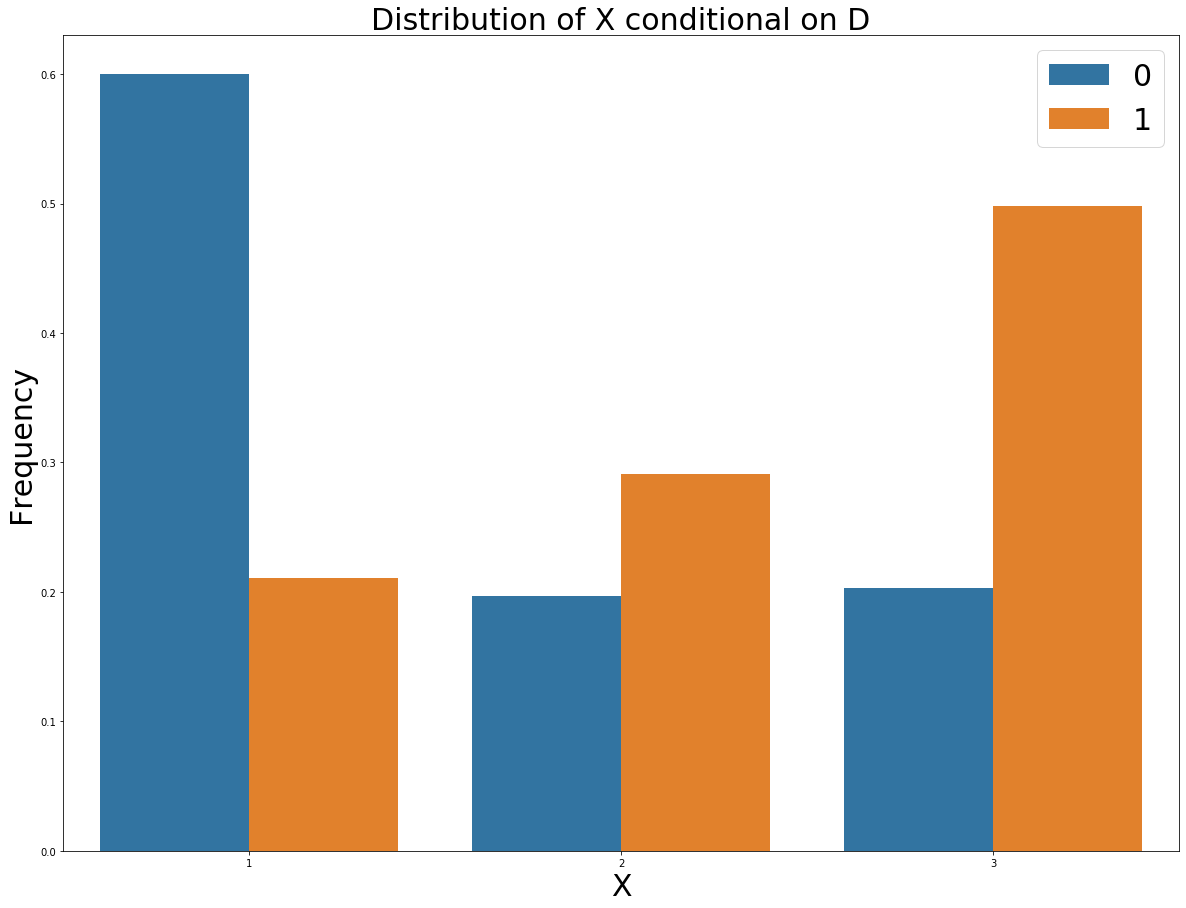

In [10]:
plt.figure(figsize = (20, 15))
df_sns = df.groupby('D')['X'].value_counts(normalize = True).rename('prop').reset_index()
sns.barplot(x = 'X', y = 'prop', hue = 'D', data = df_sns)
plt.legend(loc='upper right', fontsize=30)
plt.title('Distribution of X conditional on D', fontsize = 30)
plt.xlabel("X", fontsize=30)
plt.ylabel("Frequency", fontsize=30);

### Stratification

In [11]:
df.groupby(['D', 'X'])['Y'].mean()

D  X
0  1     2.005153
   2     4.993019
   3     9.990346
1  1     3.976192
   2     8.002779
   3    13.984996
Name: Y, dtype: float64

In [12]:
stratified_df = df.groupby(['D', 'X'])['Y'].mean()
stratified_df[1] - stratified_df[0]

X
1    1.971039
2    3.009759
3    3.994650
Name: Y, dtype: float64

In [13]:
total = pivot_df.iloc[:, :-1].sum(axis = 0)
prop = total.div(total.sum())
prop

X
1    0.405230
2    0.244205
3    0.350565
dtype: float64

In [14]:
stratified_mean_diff = stratified_df[1] - stratified_df[0]
stratified_ATE = np.sum(stratified_mean_diff * prop.values)
stratified_ATE

2.9341070078020435

## 2. Matching using Propensity score

### Simulation Data

In [15]:
def get_propensity_score(a, b):
    index = 0
    index += -2.0 + 3.0 * a - 3.0 * (a - 0.1) + 2.0 * (a - 0.3)
    index += -2.0 * (a - 0.5) + 4.0 * (a - 0.7) - 4.0 * (a - 0.9)
    index += +1.0 * b - 1.0 * (b - 0.1) + 2.0 * (b - 0.7)
    index += -2.0 * (b - 0.9)  + 3.0 * (a - 0.5) * (b - 0.5)
    index += -3.0 * (a - 0.7) * (b - 0.7)
    
    prob = np.exp(index) / (1.0 + np.exp(index))
    
    return prob

def get_potential_outcomes(a, b):
    v_0, v_1 = np.random.normal(0, 5, size=2)
    y_0 = 100.0 + 3.0 * a + 2.0 * b + v_0
    y_1 = 102.0 + 6.0 * a + 4.0 * b + v_1
    return [y_1, y_0]


def generate_propensityscore_data(a_grid, b_grid):
    sample = list()

    counts = np.tile(np.nan, (3, 100, 100))
    
    for i, a in enumerate(a_grid):
        for j, b in enumerate(b_grid):

            prob = get_propensity_score(a, b)

            # Now we determine the number of observed individuals
            for k, is_treat in enumerate([True, False]):
                if is_treat:
                    lambda_ = prob
                else:
                    lambda_ = 1.0 - prob

                num_sample = np.random.poisson(lambda_)
                counts[k, i, j] = num_sample
                
                for _ in range(num_sample):
                    d = np.random.choice([1, 0], p=[prob, 1 - prob])
                    y_1, y_0 = get_potential_outcomes(a, b)
                    y = d * y_1 + (1 - d) * y_0

                    sample += [[a, b, d, y, y_1, y_0, prob]]
            counts[2, i, j] = np.sum(counts[:2, i, j])
            
    df = pd.DataFrame(sample, columns=['a', 'b', 'd', 'y', 'y_1', 'y_0', 'p'])
    return df, counts


In [16]:
a_grid = np.linspace(0.01, 1.00, 100)
b_grid = np.linspace(0.01, 1.00, 100)

df, counts = generate_propensityscore_data(a_grid, b_grid)
df.head()

,a,b,d,y,y_1,y_0,p
0,0.01,0.01,0,104.275018,113.357801,104.275018,0.330041
1,0.01,0.05,0,105.271751,94.448048,105.271751,0.335369
2,0.01,0.07,1,98.222749,98.222749,103.381655,0.338049
3,0.01,0.07,0,99.416623,104.016972,99.416623,0.338049
4,0.01,0.08,1,101.139936,101.139936,101.992112,0.339393


### True Effect

In [17]:
true_effects = list()
true_effects += [(df['y_1'] - df['y_0'])[(df['d'] == 1)].mean()]
true_effects += [(df['y_1'] - df['y_0'])[(df['d'] == 0)].mean()]
true_effects += [(df['y_1'] - df['y_0']).mean()]

In [18]:
print('The true estimate of the average causal effect = {:5.3f}'.format(true_effects[-1]))

stat = df['y'][df['d'] == 1].mean() - df['y'][df['d'] == 0].mean()
print('The naive estimator = {:5.3f}'.format(stat))

The true estimate of the average causal effect = 4.480
The naive estimator = 4.808


### Propensity scoreの分布: common supportの可視化

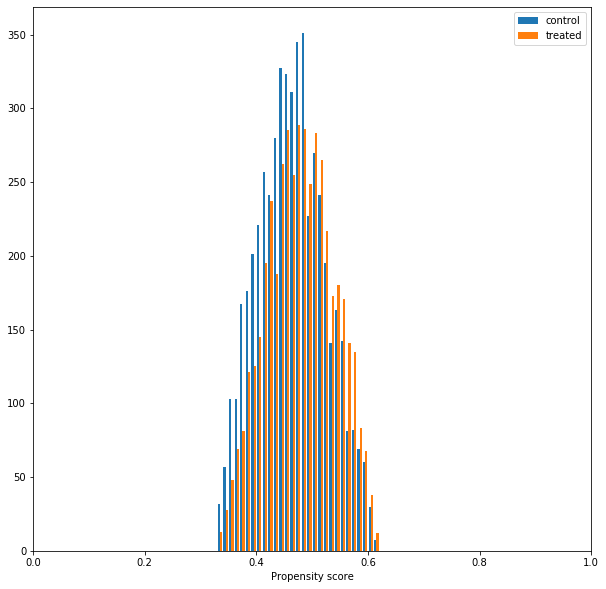

In [19]:
prob_untreated = df.loc[df['d'] == 0, 'p']
prob_treated =  df.loc[df['d'] == 1, 'p']
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
bins = np.linspace(0.01, 1.00, 100)
ax.hist([prob_untreated, prob_treated], bins=bins, label=['control', 'treated'])
ax.set_xlim([0, 1])
ax.set_xlabel('Propensity score')
ax.legend();

### Propensity Score Estimator

$$
\begin{aligned}
\hat{\delta}_{\text{ATT, weight}} &\equiv \left( \frac{1}{n^1}\sum_{i:d_i = 1} y_i\right) - \left(\frac{\sum_{i:d_i=0}\hat{r}_i y_i}{\sum_{i:d_i = 0} \hat{r}_i}\right)\\
\hat{\delta}_{\text{ATC, weight}} &\equiv 
\left(
\frac{\sum_{i: d_i = 1}\frac{y_i}{\hat{r}_i}}{\sum_{i: d_i = 1}\frac{1}{\hat{r}_i}}
\right)
- \left(\frac{1}{n^0} \sum_{i: d_i = 0} y_i\right) \\
\hat{\delta}_{\text{ATE, weight}} &\equiv \left(\frac{1}{n}\sum_{i}d_i\right) \hat{\delta}_{\text{ATT, weight}} +  \left(1 - \frac{1}{n}\sum_{i}d_i\right) \hat{\delta}_{\text{ATC, weight}}
\end{aligned}
$$

where
$$
\begin{align*}
r_i = \frac{p_i}{1 - p_i}
\end{align*}
$$

In [20]:
def get_odds(p):
    return p / (1 - p)

def get_inv_odds(p):
    return (1 - p) / p

def get_att_weight(df, p):
    """ Get weighted ATT.
    
    Calculates the weighted ATT basd on a provided
    dataset and the propensity score.
    
    Args:
        df: A dataframe with the observed data.
        p: A numpy array with the weights.
        
    Returns:
        A float which corresponds to the ATT.
    """
    weights = get_odds(p)
    
    is_control = (df['d'] == 0)
    is_treated = (df['d'] == 1)

    value, weights = df['y'][is_control], weights[is_control]
    att = df['y'][is_treated].mean() - np.average(value, weights=weights)
    
    return att
    
def get_atc_weight(df, p):
    """ Get weighted ATC.
    
    Calculates the weighted ATC basd on a provided
    dataset and the propensity score.
    
    Args:
        df: A dataframe with the observed data.
        p: A numpy array with the weights.
        
    Returns:
        A float which corresponds to the ATC.
    """
    weights = get_inv_odds(p)

    is_control = (df['d'] == 0)
    is_treated = (df['d'] == 1)

    value, weights = df['y'][is_treated], weights[is_treated]
    atc = np.average(value, weights=weights) - df['y'][is_control].mean()
    
    return atc

def get_ate_weight(df, p):
    """ Get weighted ATE.
    
    Calculates the weighted ATE basd on a provided
    dataset and the propensity score.
    
    Args:
        df: A dataframe with the observed data.
        p: A numpy array with the weights.
        
    Returns:
        A float which corresponds to the ATE.
    """
    share_treated = df['d'].value_counts(normalize=True)[1]

    atc = get_atc_weight(df, p)
    att = get_att_weight(df, p)

    return share_treated * att + (1.0 - share_treated) * atc

def get_propensity_score(df, specification='true'):
    assert specification in ['correct', 'misspecified', 'true']
    if specification == 'true':
        p = df['p']
    elif specification == 'correct':
        p = smf.logit(formula='d ~ a + b + a * b', data=df).fit().predict()
    elif specification == 'misspecified':
        p = smf.probit(formula='d ~ a + b', data=df).fit().predict()
    
    return p

rslt = dict()
for model in ['true', 'correct', 'misspecified']:
    p = get_propensity_score(df, model)

    rslt[model] = list()
    rslt[model] += [get_att_weight(df, p)]
    rslt[model] += [get_atc_weight(df, p)]
    rslt[model] += [get_ate_weight(df, p)]
    
    print('')
    print(model.capitalize())
    print('estimated: ATT {:5.3f} ATC {:5.3f} ATE {:5.3f}'.format(*rslt[model]))
    print('true:      ATT {:5.3f} ATC {:5.3f} ATE {:5.3f}'.format(*true_effects))


True
estimated: ATT 4.577 ATC 4.312 ATE 4.437
true:      ATT 4.581 ATC 4.390 ATE 4.480
Optimization terminated successfully.
         Current function value: 0.683946
         Iterations 4

Correct
estimated: ATT 4.576 ATC 4.305 ATE 4.432
true:      ATT 4.581 ATC 4.390 ATE 4.480
Optimization terminated successfully.
         Current function value: 0.683948
         Iterations 4

Misspecified
estimated: ATT 4.575 ATC 4.307 ATE 4.433
true:      ATT 4.581 ATC 4.390 ATE 4.480
